## 语义相似度模型Sentence-BERT 

* 论文地址：https://arxiv.org/abs/1908.10084
* 论文中文翻译：https://www.cnblogs.com/gczr/p/12874409.html
* 源码下载：https://github.com/UKPLab/sentence-transformers
* 相关网站：https://www.sbert.net/

* 原理：</br>
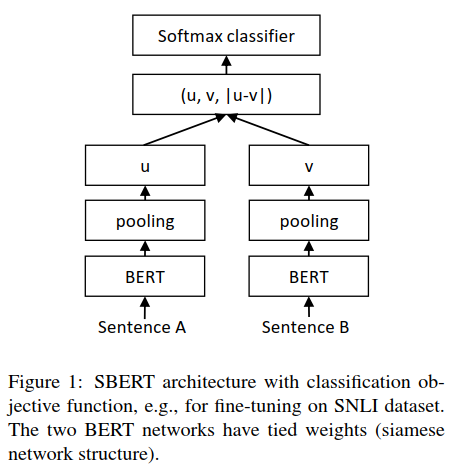</br>
* 安装方法
    * pip install sentence_transformers
    * git clone https://github.com/UKPLab/sentence-transformers.git
    
* 训练中文模型
    * 训练原理：https://www.sbert.net/docs/training/overview.html
    * 训练示例说明：https://www.sbert.net/examples/training/sts/README.html
    * 训练示例代码：examples/training/sts/training_stsbenchmark.py
* 下载中文数据：
    * git clone https://github.com/lixuanhng/NLP_related_projects.git 
    * ls NLP_related_projects/BERT/Bert_sim/data

In [ ]:
# 模型预测
from sentence_transformers import SentenceTransformer
import scipy.spatial

embedder = SentenceTransformer('bert-base-chinese')
corpus = ['这是一支铅笔',
  '关节置换术',
  '我爱北京天安门',
]
corpus_embeddings = embedder.encode(corpus)
# 待查询的句子
queries = ['心脏手术','中国首都在哪里']
query_embeddings = embedder.encode(queries)
# 对于每个句子，使用余弦相似度查询最接近的n个句子
closest_n = 2
for query, query_embedding in zip(queries, query_embeddings):
  distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]
  # 按照距离逆序
  results = zip(range(len(distances)), distances)
  results = sorted(results, key=lambda x: x[1])
  print("======================")
  print("Query:", query)
  print("Result:Top 5 most similar sentences in corpus:")
  for idx, distance in results[0:closest_n]:
    print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))

In [ ]:
# 训练过程
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import sys
import os
import pandas as pd

model_name = 'bert-base-chinese'
train_batch_size = 16
num_epochs = 4
model_save_path = 'test_output'
logging.basicConfig(format='%(asctime)s - %(message)s',
  datefmt='%Y-%m-%d %H:%M:%S',
  level=logging.INFO,
  handlers=[LoggingHandler()])

# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
  pooling_mode_mean_tokens=True,
  pooling_mode_cls_token=False,
  pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
train_samples = []
dev_samples = []
test_samples = []

def load(path):
  df = pd.read_csv(path)
  samples = []
  for idx,item in df.iterrows():
    samples.append(InputExample(texts=[item['sentence1'], item['sentence2']], label=float(item['label'])))
  return samples

train_samples = load('/workspace/exports/git/NLP_related_projects/BERT/Bert_sim/data/train.csv')
test_samples = load('/workspace/exports/git/NLP_related_projects/BERT/Bert_sim/data/test.csv')
dev_samples = load('/workspace/exports/git/NLP_related_projects/BERT/Bert_sim/data/dev.csv')

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
  evaluator=evaluator,
  epochs=num_epochs,
  evaluation_steps=1000,
  warmup_steps=warmup_steps,
  output_path=model_save_path)

model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

* 测试效果
    * 直接使用预训练的英文模型，测试集正确率21%
    * 直接使用预训练的中文模型，测试集正确率30%
    * 使用1000个用例的训练集，4次迭代，测试集正确率51%
    * 使用10000个用例的训练集，4次迭代，测试集正确率68%
    * 使用100000个用例的训练集，4次迭代，测试集正确率71%